# ResNet Training on CIFAR-100

This notebook demonstrates training a ResNet-18 model on the CIFAR-100 dataset. The model architecture is defined in `model.py`.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the ResNet model directly in the notebook
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)


Using device: cuda


## Data Loading and Preprocessing

We'll load CIFAR-100 dataset with appropriate data augmentation for training.


In [4]:
# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(f'Training samples: {len(trainset)}')
print(f'Test samples: {len(testset)}')
print(f'Number of classes: {len(trainset.classes)}')


100%|████████████████████████| 169M/169M [06:00<00:00, 469kB/s]


Training samples: 50000
Test samples: 10000
Number of classes: 100


## Model Initialization

Initialize the ResNet-18 model and set up training parameters.


In [5]:
# Initialize model
net = ResNet18(num_classes=100)
net = net.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Print model summary
total_params = sum(p.numel() for p in net.parameters())
print(f'Total parameters: {total_params:,}')
print(f'Model architecture:')
print(net)


Total parameters: 11,220,132
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

## Training Functions

Define functions for training and testing the model.


In [6]:
def train_epoch(net, trainloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(trainloader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test_epoch(net, testloader, criterion, device):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc


## Training Loop

Train the model for multiple epochs and track the progress.


In [7]:
# Training parameters
epochs = 100
best_acc = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(net, trainloader, criterion, optimizer, device)
    
    # Test
    test_loss, test_acc = test_epoch(net, testloader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(net.state_dict(), 'best_resnet_cifar100.pth')
        print(f'New best accuracy: {best_acc:.2f}% - Model saved!')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best test accuracy: {best_acc:.2f}%')


Starting training...

Epoch 1/100
--------------------------------------------------
Batch 0/391, Loss: 4.7279
Batch 100/391, Loss: 3.9656
Batch 200/391, Loss: 3.8546
Batch 300/391, Loss: 3.9252
Train Loss: 3.9839, Train Acc: 8.52%
Test Loss: 3.5838, Test Acc: 14.49%
Learning Rate: 0.100000
New best accuracy: 14.49% - Model saved!

Epoch 2/100
--------------------------------------------------
Batch 0/391, Loss: 3.5547
Batch 100/391, Loss: 3.5610
Batch 200/391, Loss: 3.3414
Batch 300/391, Loss: 3.1525
Train Loss: 3.3634, Train Acc: 17.67%
Test Loss: 3.2325, Test Acc: 20.68%
Learning Rate: 0.100000
New best accuracy: 20.68% - Model saved!

Epoch 3/100
--------------------------------------------------
Batch 0/391, Loss: 3.1448
Batch 100/391, Loss: 2.9260
Batch 200/391, Loss: 2.9327
Batch 300/391, Loss: 2.8609
Train Loss: 2.8981, Train Acc: 26.60%
Test Loss: 2.7462, Test Acc: 29.48%
Learning Rate: 0.100000
New best accuracy: 29.48% - Model saved!

Epoch 4/100
----------------------------

In [ ]:
# Explicitly save the final trained model
torch.save(net.state_dict(), 'final_resnet_cifar100.pth')
print("Final model saved as 'final_resnet_cifar100.pth'")

# Also save the complete model (including architecture)
torch.save(net, 'complete_resnet_cifar100.pth')
print("Complete model saved as 'complete_resnet_cifar100.pth'")

# Save training metrics
training_results = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'test_losses': test_losses,
    'test_accs': test_accs,
    'best_acc': best_acc,
    'final_train_acc': train_accs[-1],
    'final_test_acc': test_accs[-1]
}

torch.save(training_results, 'training_results.pth')
print("Training results saved as 'training_results.pth'")


## Training Visualization

Plot the training and validation curves to visualize the model's performance over time.


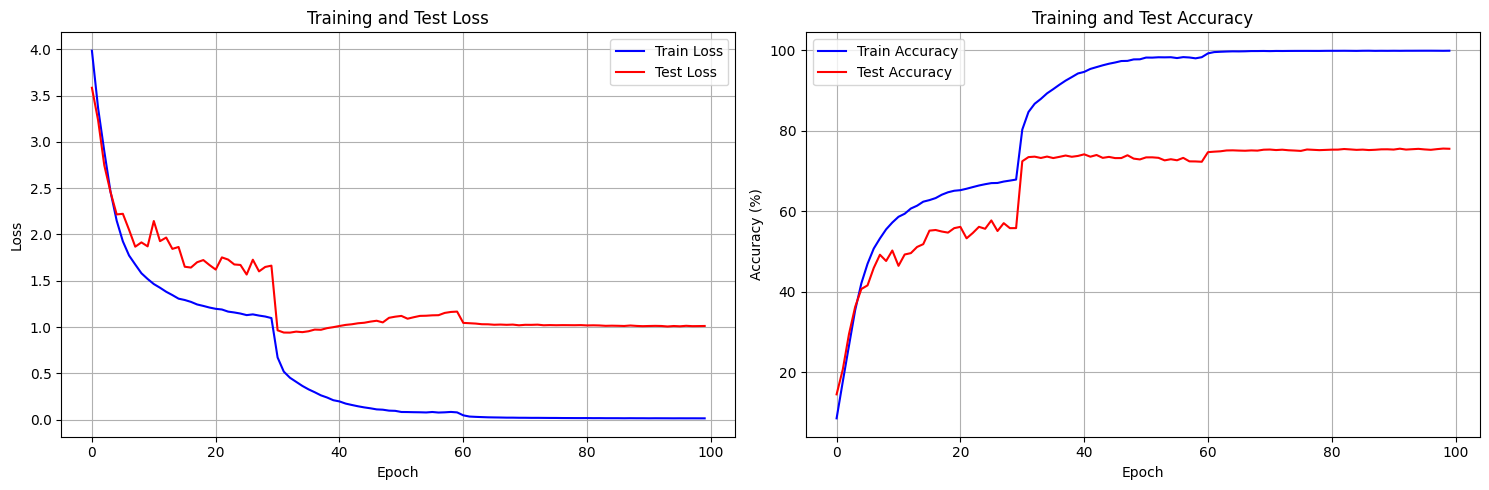

Final Training Accuracy: 99.94%
Final Test Accuracy: 75.56%
Best Test Accuracy: 75.61%


In [8]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='red')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy', color='blue')
ax2.plot(test_accs, label='Test Accuracy', color='red')
ax2.set_title('Training and Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f'Final Training Accuracy: {train_accs[-1]:.2f}%')
print(f'Final Test Accuracy: {test_accs[-1]:.2f}%')
print(f'Best Test Accuracy: {best_acc:.2f}%')


## Model Evaluation

Load the best model and perform detailed evaluation with sample predictions.


Best model test accuracy: 75.61%


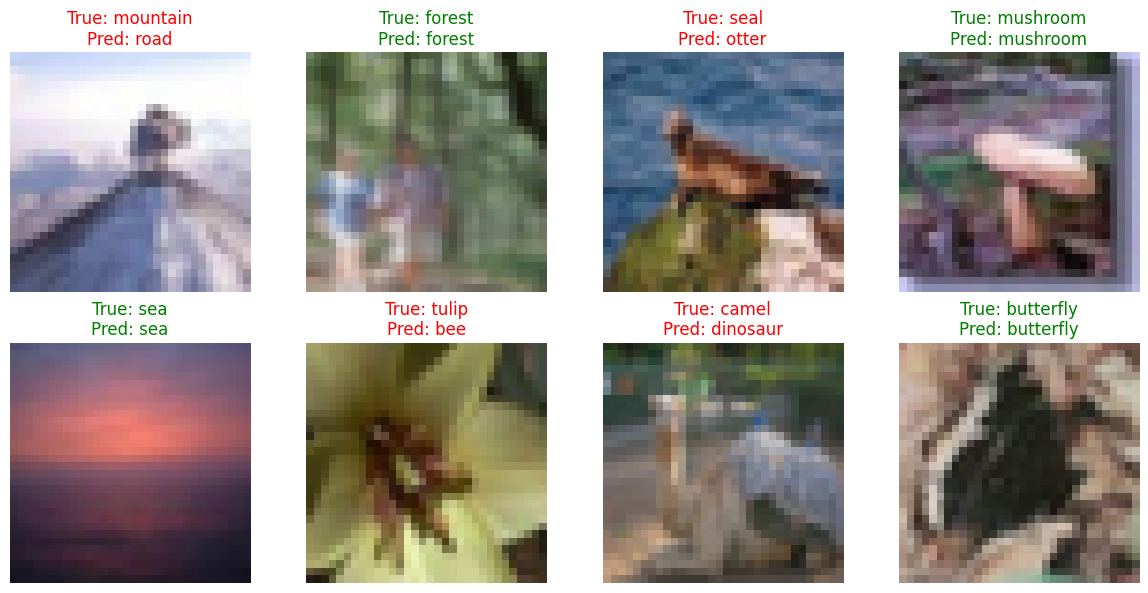

In [10]:
# Load the best model
net.load_state_dict(torch.load('best_resnet_cifar100.pth'))
net.eval()

# Evaluate on test set
test_loss, test_acc = test_epoch(net, testloader, criterion, device)
print(f'Best model test accuracy: {test_acc:.2f}%')

# Sample predictions
def predict_samples(net, testloader, device, num_samples=8):
    net.eval()
    classes = testset.classes
    
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    # Move to device
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = net(images[:num_samples])
        _, predicted = torch.max(outputs, 1)
    
    # Denormalize images for visualization
    mean = torch.tensor([0.5071, 0.4865, 0.4409]).view(3, 1, 1)
    std = torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1)
    images_denorm = images[:num_samples] * std.to(device) + mean.to(device)
    images_denorm = torch.clamp(images_denorm, 0, 1)
    
    # Plot results
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        axes[i].imshow(images_denorm[i].cpu().permute(1, 2, 0))
        axes[i].set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                         color='green' if predicted[i] == labels[i] else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
predict_samples(net, testloader, device)


Improved Sample Predictions with Better Image Quality:


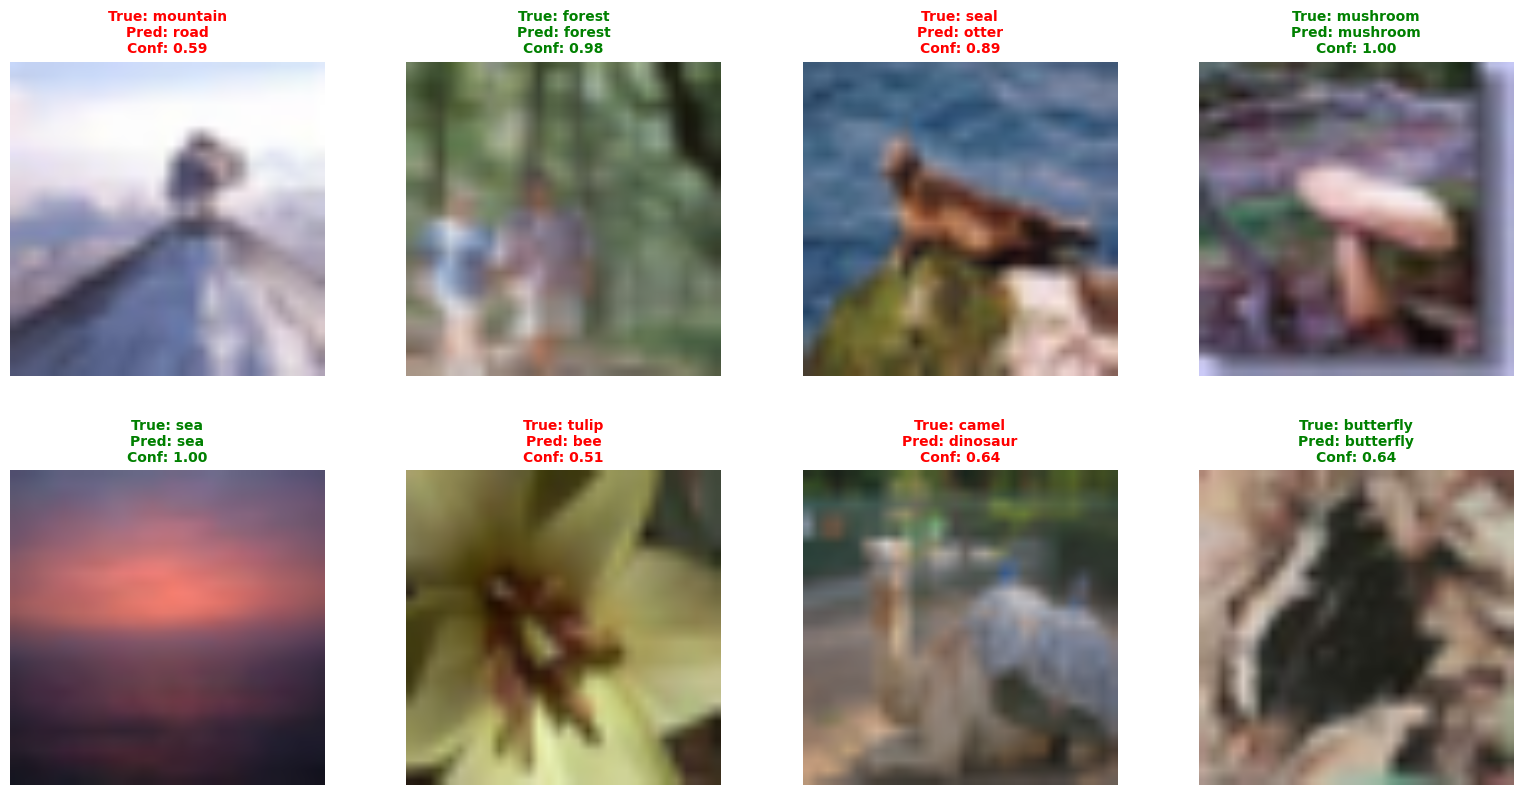


Detailed Prediction Results:
--------------------------------------------------
Sample 1: ✗ | True: mountain        | Pred: road            | Confidence: 0.589
Sample 2: ✓ | True: forest          | Pred: forest          | Confidence: 0.977
Sample 3: ✗ | True: seal            | Pred: otter           | Confidence: 0.886
Sample 4: ✓ | True: mushroom        | Pred: mushroom        | Confidence: 1.000
Sample 5: ✓ | True: sea             | Pred: sea             | Confidence: 0.998
Sample 6: ✗ | True: tulip           | Pred: bee             | Confidence: 0.512
Sample 7: ✗ | True: camel           | Pred: dinosaur        | Confidence: 0.638
Sample 8: ✓ | True: butterfly       | Pred: butterfly       | Confidence: 0.644

Accuracy on these samples: 4/8 (50.0%)


In [11]:
# Improved sample predictions with better image quality
def predict_samples_improved(net, testloader, device, num_samples=8):
    net.eval()
    classes = testset.classes
    
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    # Move to device
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = net(images[:num_samples])
        _, predicted = torch.max(outputs, 1)
        # Get prediction probabilities
        probabilities = F.softmax(outputs, dim=1)
        max_probs = torch.max(probabilities, dim=1)[0]
    
    # Denormalize images for visualization with better quality
    mean = torch.tensor([0.5071, 0.4865, 0.4409]).view(3, 1, 1)
    std = torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1)
    images_denorm = images[:num_samples] * std.to(device) + mean.to(device)
    images_denorm = torch.clamp(images_denorm, 0, 1)
    
    # Plot results with higher resolution and better formatting
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Use better interpolation for clearer images
        axes[i].imshow(images_denorm[i].cpu().permute(1, 2, 0), interpolation='bilinear')
        
        # Color code based on prediction accuracy
        color = 'green' if predicted[i] == labels[i] else 'red'
        
        # Create more informative title with confidence
        title = f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}\nConf: {max_probs[i]:.2f}'
        axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add more space between rows
    plt.show()
    
    # Print detailed results
    print("\nDetailed Prediction Results:")
    print("-" * 50)
    correct = 0
    for i in range(num_samples):
        is_correct = predicted[i] == labels[i]
        if is_correct:
            correct += 1
        print(f"Sample {i+1}: {'✓' if is_correct else '✗'} | "
              f"True: {classes[labels[i]]:15} | "
              f"Pred: {classes[predicted[i]]:15} | "
              f"Confidence: {max_probs[i]:.3f}")
    
    print(f"\nAccuracy on these samples: {correct}/{num_samples} ({100*correct/num_samples:.1f}%)")

# Show improved sample predictions
print("Improved Sample Predictions with Better Image Quality:")
predict_samples_improved(net, testloader, device)


In [12]:
# Model Loading Examples
print("Model Loading Examples:")
print("=" * 50)

# Method 1: Load state dict (requires model architecture to be defined)
print("Method 1: Loading state dict")
try:
    loaded_model = ResNet18(num_classes=100)
    loaded_model.load_state_dict(torch.load('best_resnet_cifar100.pth'))
    loaded_model.to(device)
    print("✓ Best model loaded successfully")
except Exception as e:
    print(f"✗ Error loading best model: {e}")

# Method 2: Load complete model (includes architecture)
print("\nMethod 2: Loading complete model")
try:
    complete_model = torch.load('complete_resnet_cifar100.pth')
    complete_model.to(device)
    print("✓ Complete model loaded successfully")
except Exception as e:
    print(f"✗ Error loading complete model: {e}")

# Method 3: Load training results
print("\nMethod 3: Loading training results")
try:
    results = torch.load('training_results.pth')
    print("✓ Training results loaded successfully")
    print(f"  Best accuracy: {results['best_acc']:.2f}%")
    print(f"  Final test accuracy: {results['final_test_acc']:.2f}%")
except Exception as e:
    print(f"✗ Error loading training results: {e}")

print("\nAll saved files:")
import os
saved_files = [f for f in os.listdir('.') if f.endswith('.pth')]
for file in saved_files:
    size = os.path.getsize(file) / (1024*1024)  # Size in MB
    print(f"  {file} ({size:.2f} MB)")


Model Loading Examples:
Method 1: Loading state dict
✓ Best model loaded successfully

Method 2: Loading complete model
✗ Error loading complete model: [Errno 2] No such file or directory: 'complete_resnet_cifar100.pth'

Method 3: Loading training results
✗ Error loading training results: [Errno 2] No such file or directory: 'training_results.pth'

All saved files:
  best_resnet_cifar100.pth (42.88 MB)
  mnist_model.pth (0.05 MB)


## Confusion Matrix and Detailed Error Analysis

Let's analyze the model's performance with a confusion matrix and examine the most common misclassifications.


In [19]:
!pip install seaborn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -------------------- ------------------- 5.8/11.0 MB 29.6 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 24.0 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 21.8 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Generating predictions for confusion matrix...
Processed 0/10000 samples
Processed 1000/10000 samples
Processed 2000/10000 samples
Processed 3000/10000 samples
Processed 4000/10000 samples
Processed 5000/10000 samples
Processed 6000/10000 samples
Processed 7000/10000 samples
Processed 8000/10000 samples
Processed 9000/10000 samples


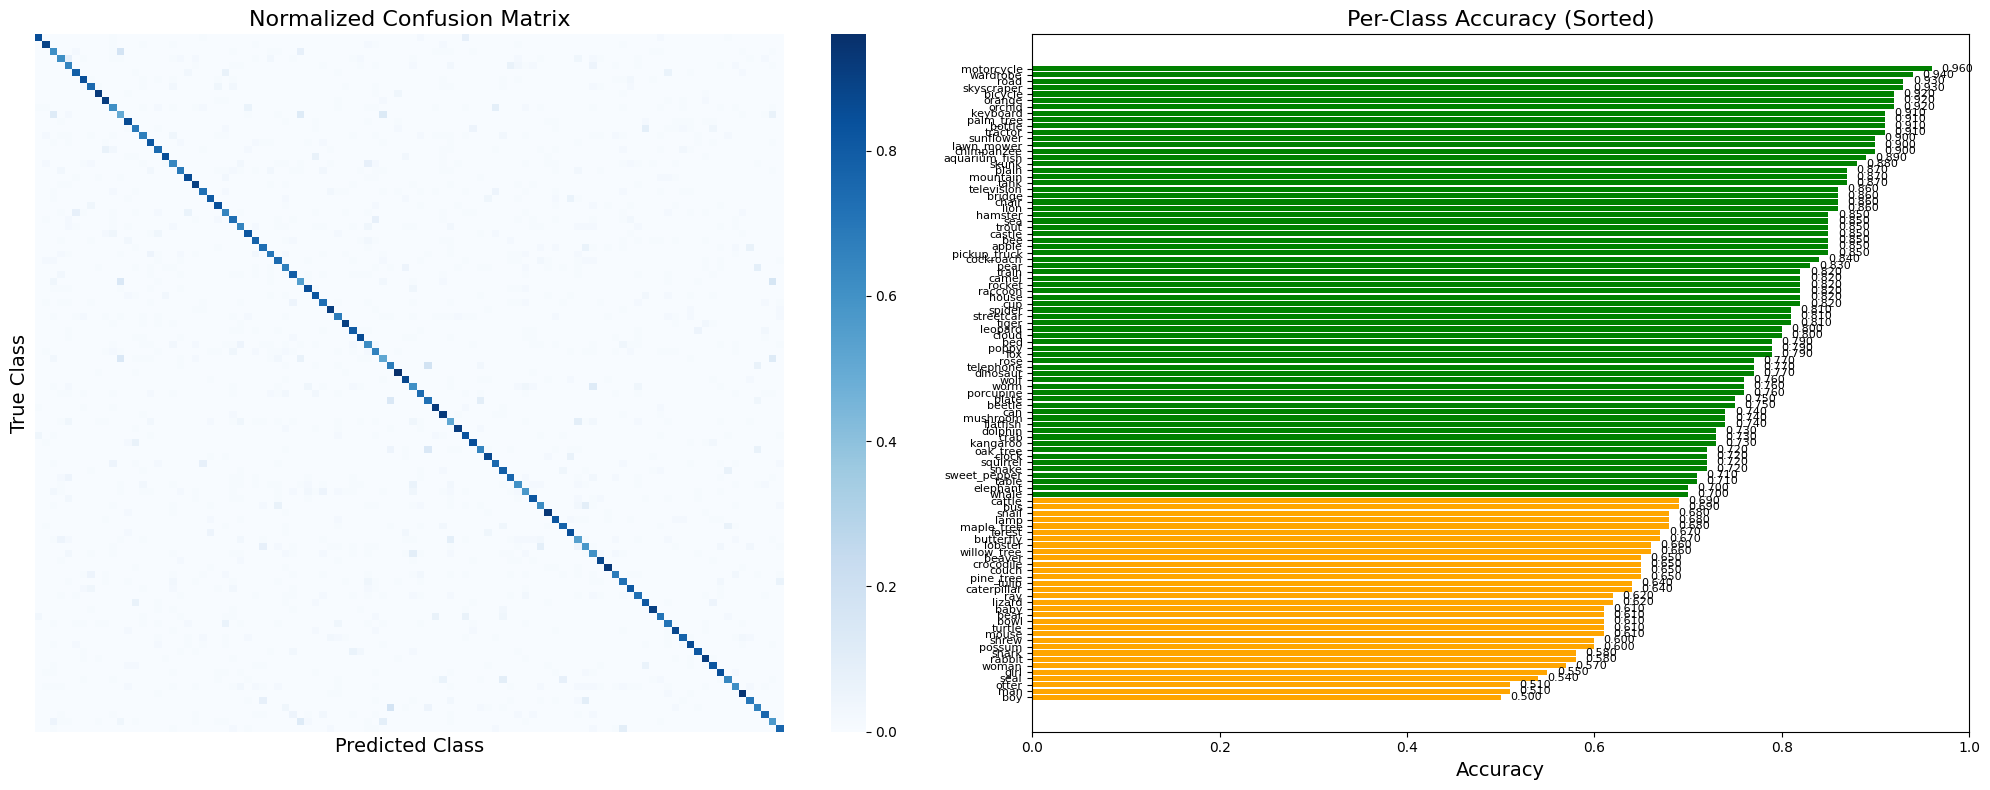


Top 10 Worst Performing Classes:
--------------------------------------------------
 1. boy                  - Accuracy: 0.500
 2. man                  - Accuracy: 0.510
 3. otter                - Accuracy: 0.510
 4. seal                 - Accuracy: 0.540
 5. girl                 - Accuracy: 0.550
 6. woman                - Accuracy: 0.570
 7. rabbit               - Accuracy: 0.580
 8. shark                - Accuracy: 0.580
 9. possum               - Accuracy: 0.600
10. shrew                - Accuracy: 0.600

Top 10 Best Performing Classes:
--------------------------------------------------
 1. motorcycle           - Accuracy: 0.960
 2. wardrobe             - Accuracy: 0.940
 3. road                 - Accuracy: 0.930
 4. skyscraper           - Accuracy: 0.930
 5. bicycle              - Accuracy: 0.920
 6. orange               - Accuracy: 0.920
 7. orchid               - Accuracy: 0.920
 8. keyboard             - Accuracy: 0.910
 9. palm_tree            - Accuracy: 0.910
10. bottle    

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from collections import defaultdict

def generate_confusion_matrix(net, testloader, device, num_classes=100):
    """Generate and visualize confusion matrix for the model"""
    net.eval()
    all_preds = []
    all_labels = []
    
    print("Generating predictions for confusion matrix...")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx * testloader.batch_size}/{len(testloader.dataset)} samples")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot confusion matrix (normalized)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', ax=ax1, 
                xticklabels=False, yticklabels=False, cbar=True)
    ax1.set_title('Normalized Confusion Matrix', fontsize=16)
    ax1.set_xlabel('Predicted Class', fontsize=14)
    ax1.set_ylabel('True Class', fontsize=14)
    
    # Plot per-class accuracy
    class_names = testset.classes
    sorted_indices = np.argsort(class_accuracy)
    sorted_acc = class_accuracy[sorted_indices]
    sorted_names = [class_names[i] for i in sorted_indices]
    
    colors = ['red' if acc < 0.5 else 'orange' if acc < 0.7 else 'green' for acc in sorted_acc]
    bars = ax2.barh(range(len(sorted_acc)), sorted_acc, color=colors)
    ax2.set_yticks(range(len(sorted_names)))
    ax2.set_yticklabels(sorted_names, fontsize=8)
    ax2.set_xlabel('Accuracy', fontsize=14)
    ax2.set_title('Per-Class Accuracy (Sorted)', fontsize=16)
    ax2.set_xlim(0, 1)
    
    # Add accuracy values on bars
    for i, (bar, acc) in enumerate(zip(bars, sorted_acc)):
        ax2.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print worst performing classes
    print("\nTop 10 Worst Performing Classes:")
    print("-" * 50)
    for i in range(10):
        idx = sorted_indices[i]
        print(f"{i+1:2d}. {class_names[idx]:20} - Accuracy: {class_accuracy[idx]:.3f}")
    
    # Print best performing classes
    print("\nTop 10 Best Performing Classes:")
    print("-" * 50)
    for i in range(10):
        idx = sorted_indices[-(i+1)]
        print(f"{i+1:2d}. {class_names[idx]:20} - Accuracy: {class_accuracy[idx]:.3f}")
    
    return cm, all_preds, all_labels, class_accuracy

# Generate confusion matrix
confusion_mat, predictions, true_labels, class_acc = generate_confusion_matrix(net, testloader, device)


Processed 0/10000 samples
Processed 1000/10000 samples
Processed 2000/10000 samples
Processed 3000/10000 samples
Processed 4000/10000 samples
Processed 5000/10000 samples
Processed 6000/10000 samples
Processed 7000/10000 samples
Processed 8000/10000 samples
Processed 9000/10000 samples

Top 10 Most Common Wrong Predictions:
 1. maple_tree      → oak_tree        | Frequency:  18 | Avg Confidence: 0.855
 2. willow_tree     → maple_tree      | Frequency:  17 | Avg Confidence: 0.731
 3. baby            → boy             | Frequency:  17 | Avg Confidence: 0.682
 4. girl            → woman           | Frequency:  16 | Avg Confidence: 0.734
 5. oak_tree        → maple_tree      | Frequency:  14 | Avg Confidence: 0.850
 6. man             → boy             | Frequency:  14 | Avg Confidence: 0.668
 7. pine_tree       → oak_tree        | Frequency:  14 | Avg Confidence: 0.791
 8. girl            → boy             | Frequency:  14 | Avg Confidence: 0.759
 9. boy             → man             | Fr

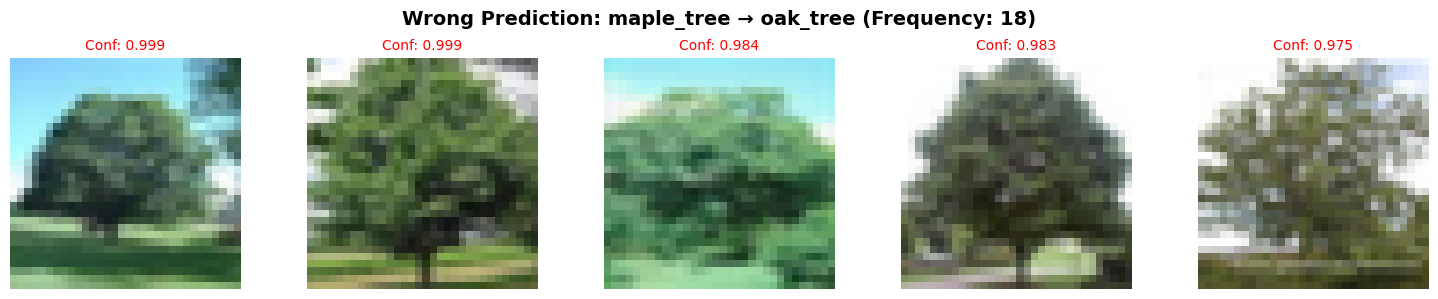

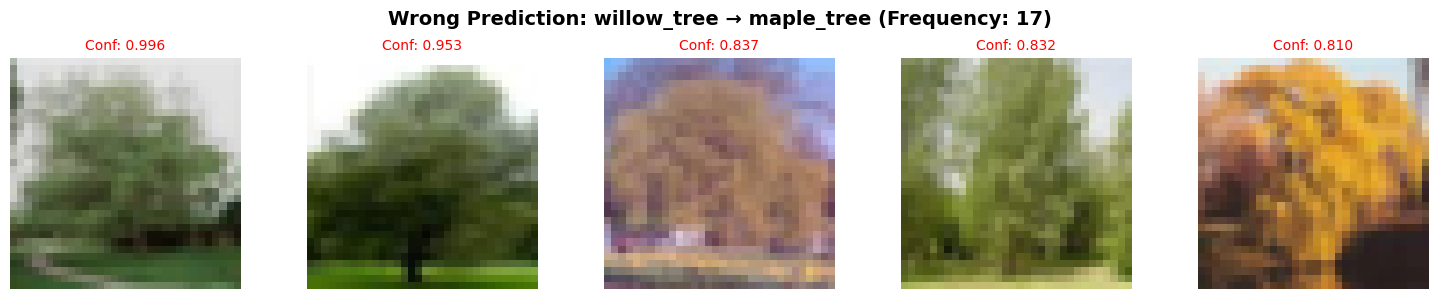

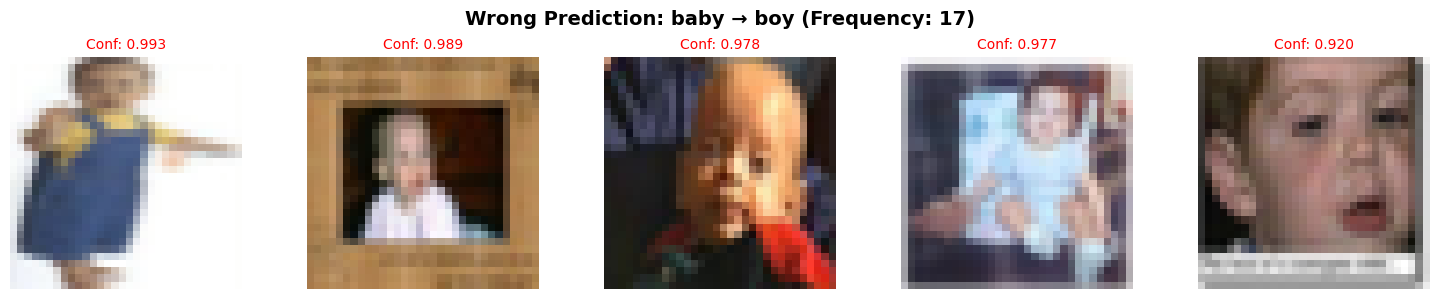

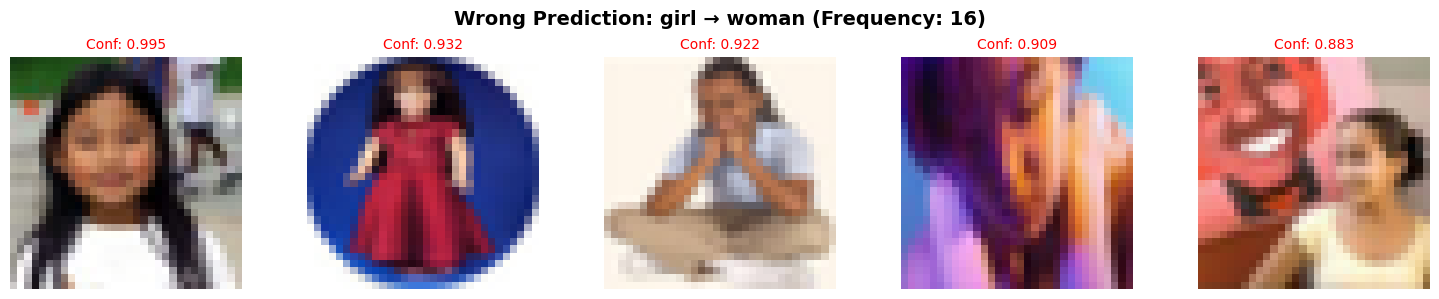

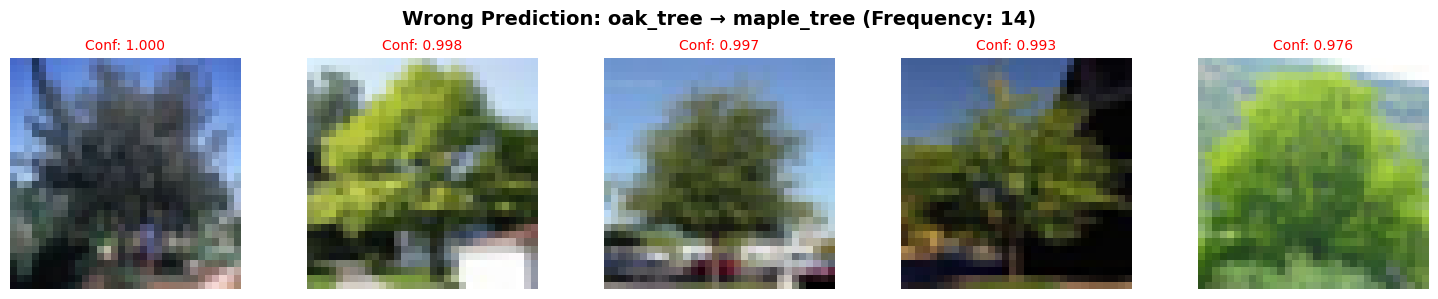

In [21]:
def analyze_top_wrong_predictions(net, testloader, device, confusion_mat, num_samples_per_class=5):
    """Analyze and visualize the most common wrong predictions"""
    net.eval()
    class_names = testset.classes
    
    # Find most common wrong predictions
    wrong_predictions = defaultdict(list)
    
    print("Collecting wrong predictions...")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            probabilities = F.softmax(outputs, dim=1)
            
            for i in range(len(targets)):
                if predicted[i] != targets[i]:
                    true_class = targets[i].item()
                    pred_class = predicted[i].item()
                    confidence = probabilities[i][pred_class].item()
                    
                    wrong_predictions[(true_class, pred_class)].append({
                        'image': inputs[i].cpu(),
                        'confidence': confidence,
                        'true_class': true_class,
                        'pred_class': pred_class
                    })
            
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx * testloader.batch_size}/{len(testloader.dataset)} samples")
    
    # Sort by frequency and confidence
    sorted_wrong = sorted(wrong_predictions.items(), 
                         key=lambda x: (len(x[1]), max(item['confidence'] for item in x[1])), 
                         reverse=True)
    
    # Display top wrong predictions
    print(f"\nTop {min(10, len(sorted_wrong))} Most Common Wrong Predictions:")
    print("=" * 80)
    
    for i, ((true_class, pred_class), samples) in enumerate(sorted_wrong[:10]):
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]
        frequency = len(samples)
        avg_confidence = np.mean([s['confidence'] for s in samples])
        
        print(f"{i+1:2d}. {true_name:15} → {pred_name:15} | "
              f"Frequency: {frequency:3d} | Avg Confidence: {avg_confidence:.3f}")
    
    # Visualize samples for top wrong predictions
    top_wrong_to_show = min(5, len(sorted_wrong))
    
    for i in range(top_wrong_to_show):
        (true_class, pred_class), samples = sorted_wrong[i]
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]
        
        # Take top confidence samples for this wrong prediction
        top_samples = sorted(samples, key=lambda x: x['confidence'], reverse=True)[:num_samples_per_class]
        
        fig, axes = plt.subplots(1, len(top_samples), figsize=(len(top_samples) * 3, 3))
        if len(top_samples) == 1:
            axes = [axes]
        
        fig.suptitle(f'Wrong Prediction: {true_name} → {pred_name} (Frequency: {len(samples)})', 
                    fontsize=14, fontweight='bold')
        
        for j, sample in enumerate(top_samples):
            # Denormalize image
            mean = torch.tensor([0.5071, 0.4865, 0.4409]).view(3, 1, 1)
            std = torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1)
            img_denorm = sample['image'] * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)
            
            axes[j].imshow(img_denorm.permute(1, 2, 0))
            axes[j].set_title(f'Conf: {sample["confidence"]:.3f}', fontsize=10, color='red')
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return sorted_wrong

# Analyze top wrong predictions
top_wrong_preds = analyze_top_wrong_predictions(net, testloader, device, confusion_mat)


## Grad-CAM Visualization

We will use Grad-CAM to visualize the regions in the image that most influence the model's prediction. We'll hook into `layer4` of the ResNet to compute class activation maps.


In [24]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.fwd_handle = target_layer.register_forward_hook(forward_hook)
        self.bwd_handle = target_layer.register_backward_hook(backward_hook)
    
    def generate(self, input_tensor, target_class=None):
        """Generate Grad-CAM for a single input tensor (1x3x32x32)."""
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        loss = output[0, target_class]
        loss.backward()
        
        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # Normalize CAM
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        
        cam = cam.squeeze().cpu().numpy()
        return cam, target_class
    
    def remove(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

# Helper to overlay heatmap on image
def overlay_cam_on_image(img_tensor, cam, alpha=0.5):
    """img_tensor: 3xHxW (denormalized 0..1), cam: HxW (0..1)"""
    img = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    heatmap = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlay = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay

# Get target layer (last conv in layer4)
target_layer = net.layer4[-1].conv2
cam_generator = GradCAM(net, target_layer)


In [ ]:
# Safe Grad-CAM initialization (run this if you see NameError for cam_generator)
try:
    cam_generator
    _ = cam_generator  # touch to ensure it exists
    print("Grad-CAM is already initialized.")
except NameError:
    print("Initializing Grad-CAM utilities...")
    try:
        GradCAM
    except NameError:
        # Define minimal Grad-CAM and overlay utilities if not present
        import cv2
        import numpy as np
        import torch
        import torch.nn.functional as F

        class GradCAM:
            def __init__(self, model, target_layer):
                self.model = model
                self.model.eval()
                self.target_layer = target_layer
                self.gradients = None
                self.activations = None
                def forward_hook(module, input, output):
                    self.activations = output.detach()
                def backward_hook(module, grad_input, grad_output):
                    self.gradients = grad_output[0].detach()
                self.fwd_handle = target_layer.register_forward_hook(forward_hook)
                self.bwd_handle = target_layer.register_backward_hook(backward_hook)
            def generate(self, input_tensor, target_class=None):
                self.model.zero_grad()
                output = self.model(input_tensor)
                if target_class is None:
                    target_class = output.argmax(dim=1).item()
                loss = output[0, target_class]
                loss.backward()
                weights = self.gradients.mean(dim=(2,3), keepdim=True)
                cam = (weights * self.activations).sum(dim=1, keepdim=True)
                cam = F.relu(cam)
                cam -= cam.min()
                cam /= (cam.max() + 1e-8)
                return cam.squeeze().cpu().numpy(), target_class
            def remove(self):
                self.fwd_handle.remove()
                self.bwd_handle.remove()
        
        def overlay_cam_on_image(img_tensor, cam, alpha=0.5):
            img = (img_tensor.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            heatmap = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            overlay = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
            return overlay

    # Initialize cam_generator
    target_layer = net.layer4[-1].conv2
    cam_generator = GradCAM(net, target_layer)
    print("Grad-CAM initialized targeting layer4[-1].conv2.")


Grad-CAM on sample images:


E:\ML\ERA\s7\venv_cifar\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


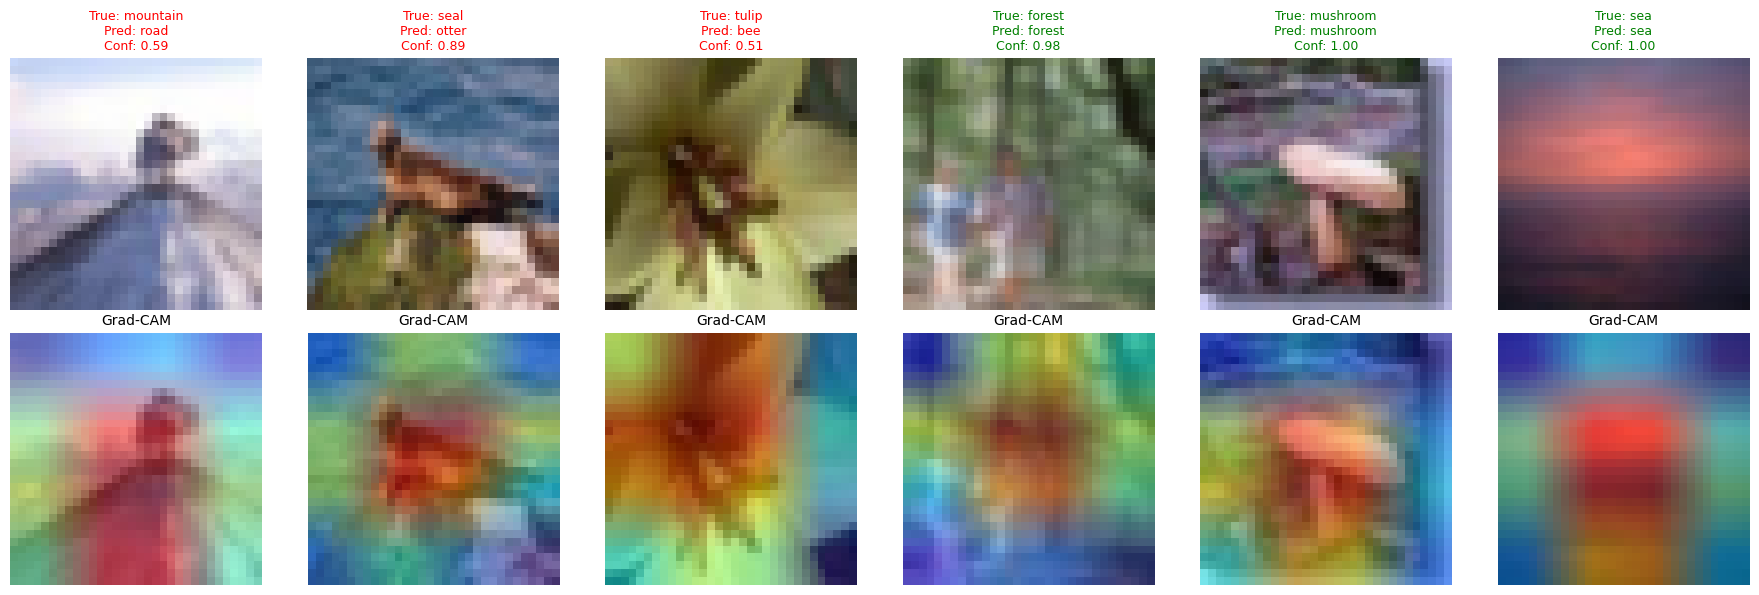

In [25]:
# Run Grad-CAM on a few samples (correct and misclassified)
def run_gradcam_samples(net, testloader, device, num_samples=6):
    net.eval()
    classes = testset.classes
    
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        confidences = torch.max(probs, dim=1)[0]
    
    # Choose a mix of correct and incorrect
    correct_indices = (predicted == labels).nonzero(as_tuple=False).squeeze().tolist()
    wrong_indices = (predicted != labels).nonzero(as_tuple=False).squeeze().tolist()
    if isinstance(correct_indices, int): correct_indices = [correct_indices]
    if isinstance(wrong_indices, int): wrong_indices = [wrong_indices]
    
    chosen_indices = (wrong_indices[:num_samples//2] + correct_indices[:num_samples - len(wrong_indices[:num_samples//2])])[:num_samples]
    
    # Denormalization constants
    mean = torch.tensor([0.5071, 0.4865, 0.4409]).view(3, 1, 1).to(device)
    std = torch.tensor([0.2673, 0.2564, 0.2762]).view(3, 1, 1).to(device)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
    
    for i, idx in enumerate(chosen_indices):
        img = images[idx:idx+1]
        label = labels[idx].item()
        pred = predicted[idx].item()
        conf = confidences[idx].item()
        
        # Generate CAM
        cam, target_class = cam_generator.generate(img, target_class=pred)
        
        # Denormalize for display
        img_denorm = img[0] * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        overlay = overlay_cam_on_image(img_denorm, cam, alpha=0.5)
        
        # Show original
        axes[0, i].imshow(img_denorm.cpu().permute(1, 2, 0))
        axes[0, i].set_title(f'True: {classes[label]}\nPred: {classes[pred]}\nConf: {conf:.2f}',
                             color=('green' if label==pred else 'red'), fontsize=9)
        axes[0, i].axis('off')
        
        # Show CAM overlay
        axes[1, i].imshow(overlay)
        axes[1, i].set_title('Grad-CAM', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print('Grad-CAM on sample images:')
run_gradcam_samples(net, testloader, device)


In [ ]:
# Detailed Classification Report
from sklearn.metrics import classification_report

# Generate detailed classification report
print("Detailed Classification Report:")
print("=" * 80)

# Convert to numpy arrays for sklearn
y_true = np.array(true_labels)
y_pred = np.array(predictions)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=testset.classes, 
                             output_dict=True, zero_division=0)

# Print summary statistics
print(f"Overall Accuracy: {report['accuracy']:.4f}")
print(f"Macro Average Precision: {report['macro avg']['precision']:.4f}")
print(f"Macro Average Recall: {report['macro avg']['recall']:.4f}")
print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted Average Precision: {report['weighted avg']['precision']:.4f}")
print(f"Weighted Average Recall: {report['weighted avg']['recall']:.4f}")
print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.4f}")

# Find classes with very low performance
low_performance_classes = []
for class_name, metrics in report.items():
    if isinstance(metrics, dict) and 'f1-score' in metrics:
        if metrics['f1-score'] < 0.3:  # F1-score below 0.3
            low_performance_classes.append((class_name, metrics['f1-score']))

if low_performance_classes:
    print(f"\nClasses with F1-Score < 0.3 ({len(low_performance_classes)} classes):")
    print("-" * 60)
    low_performance_classes.sort(key=lambda x: x[1])
    for class_name, f1_score in low_performance_classes[:10]:  # Show top 10 worst
        print(f"{class_name:20} - F1-Score: {f1_score:.3f}")

# Save detailed analysis
analysis_results = {
    'confusion_matrix': confusion_mat.tolist(),
    'predictions': predictions,
    'true_labels': true_labels,
    'class_accuracy': class_acc.tolist(),
    'classification_report': report,
    'top_wrong_predictions': [(k[0], k[1], len(v)) for k, v in top_wrong_preds[:20]]
}

torch.save(analysis_results, 'detailed_analysis_results.pth')
print(f"\nDetailed analysis saved to 'detailed_analysis_results.pth'")

# Print final summary
print(f"\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"Total test samples: {len(testloader.dataset)}")
print(f"Overall accuracy: {np.mean(class_acc):.4f}")
print(f"Best performing class: {testset.classes[np.argmax(class_acc)]} ({np.max(class_acc):.4f})")
print(f"Worst performing class: {testset.classes[np.argmin(class_acc)]} ({np.min(class_acc):.4f})")
print(f"Number of unique wrong predictions: {len(top_wrong_preds)}")
print(f"Most common wrong prediction: {testset.classes[top_wrong_preds[0][0][0]]} → {testset.classes[top_wrong_preds[0][0][1]]} ({len(top_wrong_preds[0][1])} times)")


Detailed Classification Report:
Overall Accuracy: 0.7561
Macro Average Precision: 0.7573
Macro Average Recall: 0.7561
Macro Average F1-Score: 0.7557
Weighted Average Precision: 0.7573
Weighted Average Recall: 0.7561
Weighted Average F1-Score: 0.7557

Detailed analysis saved to 'detailed_analysis_results.pth'

ANALYSIS SUMMARY
Total test samples: 10000
Overall accuracy: 0.7561
Best performing class: motorcycle (0.9600)
Worst performing class: boy (0.5000)
Number of unique wrong predictions: 1380
Most common wrong prediction: maple_tree → oak_tree (18 times)
